In [223]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, BayesianRidge, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import random
from sklearn import metrics
random.seed(0)

In [224]:
data = pd.read_csv("X_train.csv")

In [225]:
data.head()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary,gender_M,ssc_b_Others,hsc_b_Others,hsc_s_Commerce,hsc_s_Science,degree_t_Others,degree_t_Sci&Tech,workex_Yes,specialisation_Mkt&HR,status_Placed
0,0.000000,2.148760,-0.727273,-0.680851,-0.385078,0.106195,1,1,1,1,0,0,1,0,1,1
1,0.816556,1.101653,1.043636,0.659574,0.515042,-0.141593,1,0,1,0,1,0,1,1,0,1
2,-0.132450,0.247934,-0.181818,0.170213,-0.505415,0.035398,1,0,0,0,0,0,0,0,0,1
3,-0.728477,-1.074380,-1.272727,-0.212766,-0.309266,-0.849558,1,0,0,0,1,0,1,0,1,0
4,1.245033,0.710744,0.663636,1.097872,-0.782190,0.654867,1,0,0,1,0,0,0,0,0,1


In [229]:
x = data.iloc[:,[0,1,2,3,4,6,7,8,9,10,11,12,13,14]]
y = data.iloc[:,[5]]

In [230]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

## Linear Regression

[[ 0.34094717  0.10823595  0.13192284  0.21081174 -0.13506183]]
R-squared value : 	 0.6000259212083021


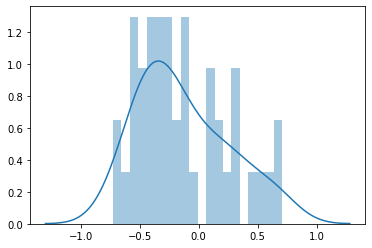

In [231]:
model = LinearRegression()
features = SelectFromModel(model)
features.fit(x_train, y_train)
selected_feat = x_train.columns[(features.get_support())]
xFeatTrain = x_train[selected_feat]
xFeatTest = x_test[selected_feat]
model.fit(xFeatTrain, y_train)
pred = model.predict(xFeatTest)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## OLS

In [252]:
xOLS = sm.add_constant(x)
#reject features with p-value>0.05 and check if rsquared goes up or not

Created a function BackwardEliminationRAquared to reject features with p-values>0.5 but at the same time check if it affects R-Squared value.
To be precise R-Squared value should increase on removing features.

In [253]:
def BackwardEliminationRSquared(x,y,SL):
    maxvar = len(x[0])
    temp = np.zeros(shape=x.shape).astype(int)
    for i in range(maxvar):
        regressor_ols = sm.OLS(endog=y,exog=x).fit()
        adjR_before = regressor_ols.rsquared_adj.astype(float)
        maxP = max(regressor_ols.pvalues).astype(float)
        if (maxP>SL):
            for j in range(maxvar-i):
                if(regressor_ols.pvalues[j]==maxP):
                    temp[:,j] = x[:,j]
                    x = np.delete(arr=x,obj=j,axis=1)
                    tmp_regressor = sm.OLS(endog=y,exog=x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before>=adjR_after):
                        
                        x_rollback = np.hstack(((x,temp[:,[j]]))) #makes temp a 2-D array
                        print(regressor_ols.summary())
                        return x_rollback
                    else:
                        continue

In [254]:
x_modeled = BackwardEliminationRSquared(xOLS.values,y.values,0.05)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     22.48
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           1.66e-22
Time:                        14:00:23   Log-Likelihood:                -114.43
No. Observations:                 215   AIC:                             244.9
Df Residuals:                     207   BIC:                             271.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2896      0.064     -4.539      0.0

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     22.48
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           1.66e-22
Time:                        14:00:33   Log-Likelihood:                -114.43
No. Observations:                 215   AIC:                             244.9
Df Residuals:                     207   BIC:                             271.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2896      0.064     -4.539      0.0

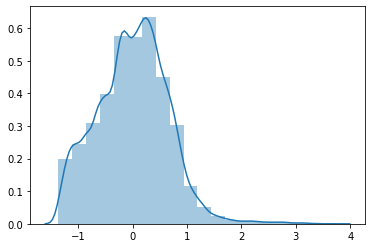

In [256]:
model = sm.OLS(y, x_modeled).fit()
print(model.summary())
print(model.params)
print("\nR-squared value : \t", model.rsquared)
pred = model.predict(x_modeled)
sns.distplot(y.values - pred, bins=20)

## Ridge

{'tol': 1e-10, 'solver': 'auto', 'alpha': 5}
-0.20294977150223156
[[ 0.29235866  0.12618481  0.10743407 -0.03931645 -0.08020511  0.11483276
   0.05885229 -0.06600853 -0.02794021  0.01219119 -0.04518599 -0.03179283
   0.21210266 -0.11930039]]
R-squared value : 	 0.617298458188794


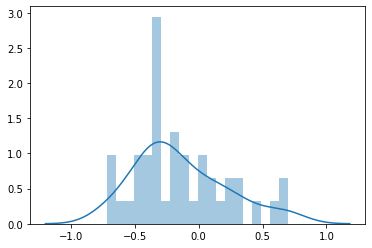

In [236]:
ridge = Ridge()
param = {'alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'tol':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

model = RandomizedSearchCV(ridge, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train, y_train)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

[[ 0.28341756  0.10068733  0.09319459  0.13432794  0.18875579 -0.11550822]]
R-squared value : 	 0.6128922731523194


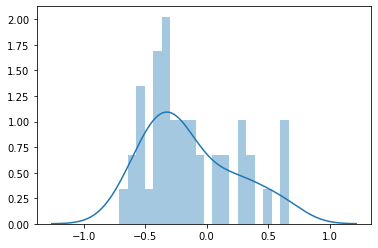

In [237]:
features = SelectFromModel(model)
features.fit(x_train, y_train)
selected_feat = x_train.columns[(features.get_support())]
xFeatTrain = x_train[selected_feat]
xFeatTest = x_test[selected_feat]
model.fit(xFeatTrain, y_train)
pred = model.predict(xFeatTest)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## Elastic Net

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.370511886237644, tolerance: 4.72531984568009e-14
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.255416832789145, tolerance: 4.564461782156032e-14
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.054725470847766, tolerance: 4.2874650540654966e-14
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

{'tol': 0.001, 'selection': 'random', 'max_iter': 10000.0, 'l1_ratio': 0.01, 'alpha': 0.01}
-0.20578735231826673
[ 0.30637568  0.12691066  0.10632738 -0.04661303 -0.08831306  0.12110095
  0.07138043 -0.07997141 -0.04031903  0.01020638 -0.06940835 -0.04523742
  0.22984963 -0.1235442 ]
R-squared value : 	 0.6137554597847994


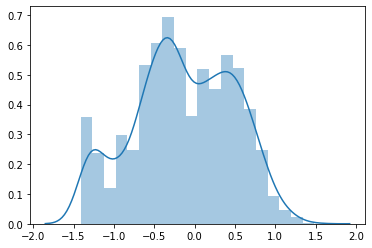

In [238]:
elastic = ElasticNet()
param = {'alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'l1_ratio':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'tol':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'selection':['cyclic', 'random'], 
         'max_iter':[1e3, 1e4, 1e5, 1e6, 1e7]}
model = RandomizedSearchCV(elastic, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train, y_train)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

[ 0.29614759  0.09756546  0.09101607  0.1435847   0.20047887 -0.11979874]
R-squared value : 	 0.6109732355251323


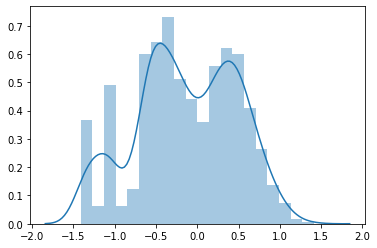

In [239]:
features = SelectFromModel(model)
features.fit(x_train, y_train)
selected_feat = x_train.columns[(features.get_support())]
xFeatTrain = x_train[selected_feat]
xFeatTest = x_test[selected_feat]
model.fit(xFeatTrain, y_train)
pred = model.predict(xFeatTest)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## Lasso

{'tol': 1e-15, 'selection': 'cyclic', 'alpha': 0.01}
-0.20123934817914008
[ 0.30232237  0.1070477   0.08481096 -0.         -0.0566188   0.08608508
  0.         -0.         -0.         -0.         -0.         -0.
  0.18906851 -0.09774439]
R-squared value : 	 0.6159769754806048


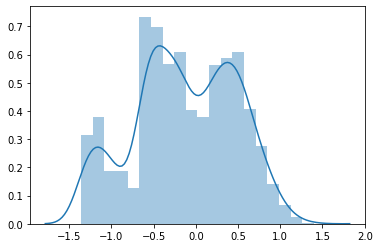

In [240]:
lasso = Lasso()
param = {'alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'tol':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'selection':['cyclic', 'random']}

model = RandomizedSearchCV(lasso, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train, y_train)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

[ 0.30232237  0.1070477   0.08481096 -0.0566188   0.08608508  0.18906851
 -0.09774439]
R-squared value : 	 0.6159769754806048


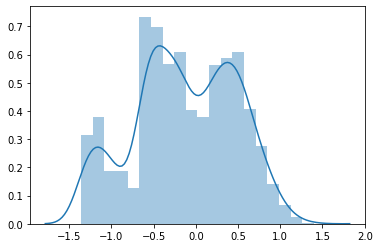

In [241]:
features = SelectFromModel(model)
features.fit(x_train, y_train)
selected_feat = x_train.columns[(features.get_support())]
xFeatTrain = x_train[selected_feat]
xFeatTest = x_test[selected_feat]
model.fit(xFeatTrain, y_train)
pred = model.predict(xFeatTest)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## Bayesian Ridge

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'tol': 1, 'n_iter': 500000, 'lambda_2': 0.001, 'lambda_1': 0.001, 'alpha_2': 0.001, 'alpha_1': 45}
-0.20269937930402068
[ 0.28520844  0.12579153  0.10753093 -0.03551565 -0.07605709  0.1113876
  0.05329967 -0.05974892 -0.02393791  0.01178654 -0.03710055 -0.02605066
  0.20342867 -0.11680615]
R-squared value : 	 0.6187573123842638


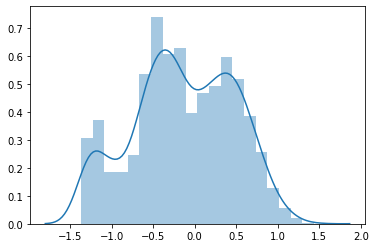

In [242]:
bayesian = BayesianRidge()
param = {'alpha_1':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
         'alpha_2':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'lambda_1':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
         'lambda_2':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
         'tol':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'n_iter':[10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]}

model = RandomizedSearchCV(bayesian, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train.values, y_train.values)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

[ 0.2875099   0.09969444  0.09259566  0.13739621  0.19255886 -0.11697146]
R-squared value : 	 0.6123204996640934


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


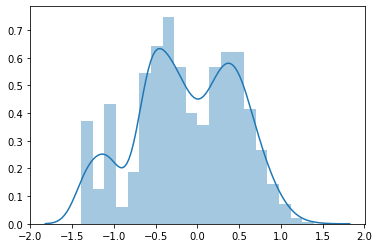

In [243]:
features = SelectFromModel(model)
features.fit(x_train, y_train)
selected_feat = x_train.columns[(features.get_support())]
xFeatTrain = x_train[selected_feat]
xFeatTest = x_test[selected_feat]
model.fit(xFeatTrain, y_train)
pred = model.predict(xFeatTest)
sns.distplot(y_test.values - pred, bins=20)
print(model.coef_)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## RANSAC

{'stop_score': 40, 'stop_probability': 0.01, 'stop_n_inliers': 55, 'min_samples': 15, 'max_trials': 500}
-0.3095818927995423
R-squared value : 	 0.561697299286015


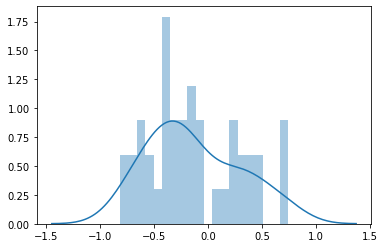

In [257]:
ransac = RANSACRegressor()
param = {'stop_n_inliers':[1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
         'stop_score':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
         'stop_probability':[1e-30, 1e-25, 1e-20, 1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2],
         'max_trials':[10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000], 
         'min_samples':[1, 5, 10, 15, 20]}

model = RandomizedSearchCV(ransac, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train.values, y_train.values)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## Decision Tree Regressor

{'splitter': 'best', 'min_weight_fraction_leaf': 0.5, 'min_samples_split': 30, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.5, 'max_leaf_nodes': 10, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'friedman_mse', 'ccp_alpha': 40}
-0.3159452051142163
R-squared value : 	 0.5040682291051531


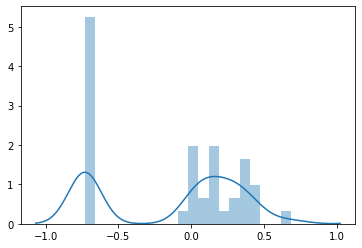

In [245]:
tree = DecisionTreeRegressor()
param = {'criterion':["mse", "friedman_mse", "mae"],
         'splitter':["best", "random"], 
         'ccp_alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
         'max_depth':[None,3,6,9,12], 'min_samples_split':[50,30,10,5, 2], 
         'min_samples_leaf':[1,5,9,12], 'min_weight_fraction_leaf':[0, 0.1, 0.2, 0.5], 
         'max_features':['auto', 'sqrt', 'log2'], 'max_leaf_nodes':[None, 50, 100, 10], 
         'min_impurity_decrease':[0.0, 0.5, 1.0, 1.5]}

model = RandomizedSearchCV(tree, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train.values, y_train.values)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

R-squared value : 	 0.5040682291051531


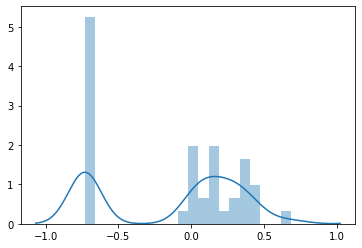

In [246]:
features = SelectFromModel(model)
features.fit(x_train, y_train)
selected_feat = x_train.columns[(features.get_support())]
xFeatTrain = x_train[selected_feat]
xFeatTest = x_test[selected_feat]
model.fit(xFeatTrain, y_train)
pred = model.predict(xFeatTest)
sns.distplot(y_test.values - pred, bins=20)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## MLP Regressor

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when 

{'tol': 0.01, 'solver': 'sgd', 'momentum': 1e-05, 'max_iter': 10000, 'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'batch_size': 20, 'alpha': 1e-10, 'activation': 'logistic'}
-0.22814262512705033
R-squared value : 	 0.6225405469411889


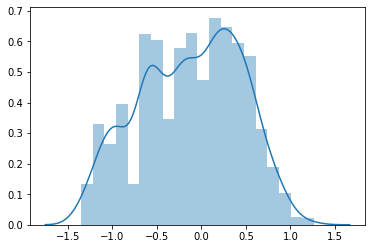

In [248]:
mlp = MLPRegressor()
param = {'activation':["identity", "logistic", "tanh", "relu"],
         'solver':["lbfgs", "sgd", "adam"], 
         'alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
         'learning_rate_init':[0, 0.1, 0.2, 0.5], 
         'learning_rate':['constant', 'invscaling', 'adaptive'],
         'tol':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100], 
         'max_iter':[10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000],
         'batch_size':[10,20,30, 50, 70, 80], 
         'momentum' : [1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3, 1e-2]}

model = RandomizedSearchCV(mlp, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train.values, y_train.values)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## K Neighbours Regressor

{'weights': 'distance', 'n_neighbors': 10, 'algorithm': 'ball_tree'}
-0.19650612236789936
R-squared value : 	 0.5835115717250203


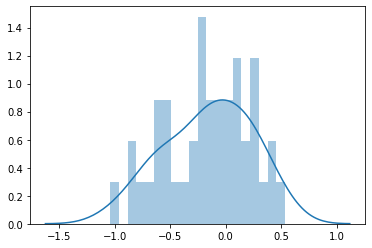

In [249]:
knn = KNeighborsRegressor()
param = {'algorithm':["auto", "ball_tree", "kd_tree", "brute"],
         'weights':["uniform", "distance"],
         'n_neighbors':[1,5,10,15,20,25]}

model = RandomizedSearchCV(knn, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train.values, y_train.values)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## SVR

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'tol': 1e-08, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 7}
-0.20103462848668213
R-squared value : 	 0.6200380685681588


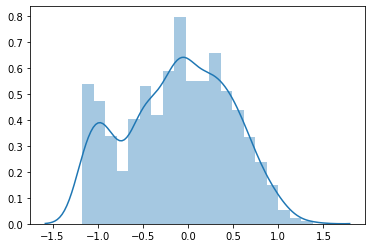

In [250]:
svm = SVR()
param = {'kernel':["linear", "poly", "rbf", "sigmoid"],
         'degree' : [1,2,3,4,5,6,7,8],
         'gamma':["scale", "auto"],
         'tol':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100]}

model = RandomizedSearchCV(svm, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train.values, y_train.values)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## Gaussian Process Regressor

{'alpha': 1}
-0.22698699400407202
R-squared value : 	 0.5509936934710291


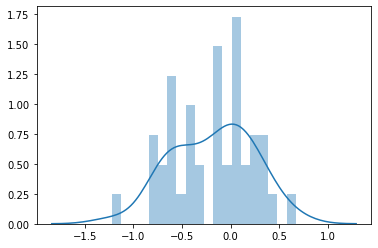

In [251]:
gaussian = GaussianProcessRegressor()
param = {'alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100]}

model = RandomizedSearchCV(gaussian, param, scoring="neg_mean_squared_error", cv=5)

model.fit(x_train.values, y_train.values)
print(model.best_params_)
print(model.best_score_)
model = model.best_estimator_
pred = model.predict(x_test)
sns.distplot(y_test.values - pred, bins=20)
#higher the value better the fit
print("R-squared value : \t", 1 - np.sqrt(metrics.mean_squared_error(y_test, pred)))

## OUTCOMES

So, outcomes are as follows : 

R-Squared values of different models are as follows:

> The highes the R-Square better the model is.

1.   Linear Regression (with feature selecton) : 0.6000259212083021
2.   OLS : 0.4318726973970223
3. Ridge (without feature selection) : 0.617298458188794
4. Ridge (with feature selection) : 0.6128922731523194
5. ElasticNet (without feature selection) : 0.6137554597847994
6. ElasticNet (with feature selection) : 0.6109732355251323
7. Lasso (without feature selection) : 0.6159769754806048
8. Lasso (with feature selection) : 0.6159769754806048
9. Bayesian Ridge (without feature selection) : 0.6187573123842638
10. Bayesian Ridge (with feature selection) : 0.6123204996640934
11. RANSAC : 0.561697299286015
12. Decision Tree Regressor (without feature selection) : 0.5040682291051531
13. Decision Tree Regressor (with feature selection) : 0.5040682291051531
14. MLP Regressor : 0.6225405469411889
15. K Neighbours Regressor : 0.5835115717250203
16. SVR : 0.6200380685681588
17. Gaussian Process Regressor : 0.5509936934710291





Now, I would define the parameters for each of the regression models : 


1. Ridge : ``` {'tol': 1e-10, 'solver': 'auto', 'alpha': 5} ```

3. ElasticNet : ```{'tol': 0.001, 'selection': 'random', 'max_iter': 10000.0, 'l1_ratio': 0.01, 'alpha': 0.01}```
4. Lasso : ```{'tol': 1e-15, 'selection': 'cyclic', 'alpha': 0.01}```
5. Bayesian Ridge : ```{'tol': 1, 'n_iter': 500000, 'lambda_2': 0.001, 'lambda_1': 0.001, 'alpha_2': 0.001, 'alpha_1': 45}```
6. RANSAC : ```{'stop_score': 40, 'stop_probability': 0.01, 'stop_n_inliers': 55, 'min_samples': 15, 'max_trials': 500}```
7. Decision Tree Regressor : ```{'splitter': 'best', 'min_weight_fraction_leaf': 0.5, 'min_samples_split': 30, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.5, 'max_leaf_nodes': 10, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'friedman_mse', 'ccp_alpha': 40}```

8. MLP Regressor : ```{'tol': 0.01, 'solver': 'sgd', 'momentum': 1e-05, 'max_iter': 10000, 'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'batch_size': 20, 'alpha': 1e-10, 'activation': 'logistic'}```
9. K Neighbours Regressor : ```{'weights': 'distance', 'n_neighbors': 10, 'algorithm': 'ball_tree'}```
16. SVR : ```{'tol': 1e-08, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 7}```
17. Gaussian Process Regressor : ```{'alpha': 1}```
